In [113]:
import os
import math
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    GlobalAveragePooling2D, Dense, Dropout, Input
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [114]:
# **Step 1: Load Metadata**
# Load the metadata file containing paths, gender, and other details
data_dir = 'D:/Users/Busters/Downloads/wiki/wiki'
metadata_file = os.path.join(data_dir, 'wiki.mat')
metadata = scipy.io.loadmat(metadata_file)

# Extract metadata details
wiki_data = metadata['wiki'][0, 0]
all_image_paths = wiki_data['full_path'][0]
genders = wiki_data['gender'][0]
birthdates = wiki_data['dob'][0]
photo_taken = wiki_data['photo_taken'][0]
face_scores = wiki_data['face_score'][0]
second_face_scores = wiki_data['second_face_score'][0]

# **Helper Function: Convert MATLAB Date to Python Datetime**
def convert_matlab_date(dob):
    """Convert MATLAB serial date to Python datetime."""
    try:
        reference_date = datetime(1, 1, 1)  # MATLAB's base date
        days = int(dob) - 366  # Adjust by 366 days for MATLAB offset
        return reference_date + timedelta(days=days)
    except ValueError:
        return None

# Calculate ages based on date of birth and photo year
ages = []
for dob, year in zip(birthdates, photo_taken):
    birth_date = convert_matlab_date(dob)
    if birth_date:
        ages.append(year - birth_date.year)  # Approximate age
    else:
        ages.append(None)

# **Filter Data Based on Quality Criteria**
filtered_data = []
for i in range(len(all_image_paths)):
    if (
        not math.isnan(face_scores[i]) and face_scores[i] > 4.5 and  # Ensure high face detection score
        math.isnan(second_face_scores[i]) and  # Exclude images with multiple faces
        not math.isnan(genders[i])  # Include only valid gender labels
    ):
        filtered_data.append({
            'path': all_image_paths[i],
            'gender': genders[i],
            'age': ages[i]
        })

# Extract paths, genders, and ages from filtered data
filtered_image_paths = [os.path.join(data_dir, item['path'][0]) for item in filtered_data]
filtered_genders = np.array([item['gender'] for item in filtered_data])
filtered_ages = np.array([item['age'] for item in filtered_data])

C:\Users\Busters\AppData\Local\Temp\ipykernel_41776\536036891.py:31: RuntimeWarning: overflow encountered in scalar subtract
  ages.append(year - birth_date.year)  # Approximate age


In [115]:
# **Step 2: Define Custom Data Generator**
def custom_data_generator(image_paths, gender_labels, age_labels, batch_size, augment=False):
    """Generate batches of images and labels with optional augmentation."""
    datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0 / 255.0,  # Normalize pixel values
        rotation_range=15 if augment else 0,  # Rotate images (training only)
        width_shift_range=0.1 if augment else 0,
        height_shift_range=0.1 if augment else 0,
        shear_range=0.1 if augment else 0,
        zoom_range=0.1 if augment else 0,
        horizontal_flip=augment  # Flip images horizontally (training only)
    )
    while True:
        for i in range(0, len(image_paths), batch_size):
            batch_images = []
            batch_gender_labels = []
            batch_age_labels = []
            for j in range(i, min(i + batch_size, len(image_paths))):
                try:
                    img = tf.keras.preprocessing.image.load_img(image_paths[j], target_size=(128, 128))
                    img = tf.keras.preprocessing.image.img_to_array(img)
                    img = datagen.random_transform(img) if augment else img
                    batch_images.append(img)
                    batch_gender_labels.append(gender_labels[j])
                    batch_age_labels.append(age_labels[j])
                except Exception as e:
                    print(f"Error processing file {image_paths[j]}: {e}")
                    continue
            yield (
                np.array(batch_images),
                {'gender': np.array(batch_gender_labels), 'age': np.array(batch_age_labels)}
            )

In [116]:
# **Step 3: Split Data into Training and Testing Sets**
split_idx = int(0.8 * len(filtered_image_paths))
train_image_paths = filtered_image_paths[:split_idx]
test_image_paths = filtered_image_paths[split_idx:]
y_train_genders = tf.keras.utils.to_categorical(filtered_genders[:split_idx], num_classes=2)
y_test_genders = tf.keras.utils.to_categorical(filtered_genders[split_idx:], num_classes=2)
y_train_ages = filtered_ages[:split_idx]
y_test_ages = filtered_ages[split_idx:]

batch_size = 64
train_generator = custom_data_generator(train_image_paths, y_train_genders, y_train_ages, batch_size, augment=True)
validation_generator = custom_data_generator(test_image_paths, y_test_genders, y_test_ages, batch_size, augment=False)

In [117]:
# **Step 4: Define Model**
base_model = MobileNetV2(include_top=False, input_shape=(128, 128, 3), weights='imagenet')
base_model.trainable = False  # Freeze pre-trained layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Output layer for gender classification
gender_output = Dense(2, activation='softmax', name='gender')(x)
# Output layer for age prediction
age_output = Dense(1, activation='linear', name='age')(x)

# Compile the model
model = Model(inputs=base_model.input, outputs=[gender_output, age_output])
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'gender': 'categorical_crossentropy', 'age': 'mean_squared_error'},
    metrics={'gender': 'accuracy', 'age': 'mae'}
)

In [118]:
# **Step 5: Train the Model**
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(test_image_paths) // batch_size

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 23s 254ms/step - age_loss: 387.0529 - age_mae: 15.2297 - gender_accuracy: 0.5135 - gender_loss: 1.8892 - loss: 388.9421 - val_age_loss: 187.5989 - val_age_mae: 10.6607 - val_gender_accuracy: 0.5573 - val_gender_loss: 0.7092 - val_loss: 188.3081 - learning_rate: 0.0010
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - age_loss: 203.5532 - age_mae: 11.0308 - gender_accuracy: 0.5311 - gender_loss: 1.3546 - loss: 205.0217 - val_age_loss: 179.3099 - val_age_mae: 10.6028 - val_gender_accuracy: 0.5833 - val_gender_loss: 0.6717 - val_loss: 179.9817 - learning_rate: 0.0010
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - age_loss: 193.7138 - age_mae: 10.7874 - gender_accuracy: 0.5363 - gender_loss: 0.8984 - loss: 194.0328 - val_age_loss: 177.4102 - val_age_mae: 10.4006 - val_gender_accuracy: 0.5781 - val_gender_loss: 0.7287 - val_loss: 178.1388 - learning_rate: 0.0010
Epoch 4/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 231ms/step - age_loss: 193.8602 - age

In [119]:
# **Step 6: Evaluate the Model**
results = model.evaluate(validation_generator, steps=validation_steps)
print("Test Results:", results)

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 129ms/step - age_loss: 172.8403 - age_mae: 10.3713 - gender_accuracy: 0.5919 - gender_loss: 0.6699 - loss: 177.0907
Test Results: [174.8507843017578, 0.6737504601478577, 169.9182891845703, 10.286042213439941, 0.5819735527038574]


In [120]:
# **Step 7: Generate Predictions**
predictions = model.predict(validation_generator, steps=validation_steps)
predicted_genders = np.argmax(predictions[0], axis=1)
predicted_ages = predictions[1].flatten()

true_genders = []
true_ages = []
for _, labels in validation_generator:
    true_genders.extend(np.argmax(labels['gender'], axis=1))
    true_ages.extend(labels['age'])
    if len(true_genders) >= len(predicted_genders):
        break
true_genders = np.array(true_genders[:len(predicted_genders)])
true_ages = np.array(true_ages[:len(predicted_ages)])

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(true_genders, predicted_genders, target_names=['Female', 'Male']))
print("Confusion Matrix:")
print(confusion_matrix(true_genders, predicted_genders))

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step
Classification Report:
              precision    recall  f1-score   support

      Female       0.00      0.00      0.00       538
        Male       0.58      1.00      0.74       749

    accuracy                           0.58      1287
   macro avg       0.29      0.50      0.37      1287
weighted avg       0.34      0.58      0.43      1287

Confusion Matrix:
[[  0 538]
 [  0 749]]


c:\Users\Busters\Documents\GitHub\faces-cnn\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Busters\Documents\GitHub\faces-cnn\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Busters\Documents\GitHub\faces-cnn\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

IndexError: index 1331 is out of bounds for axis 0 with size 1287

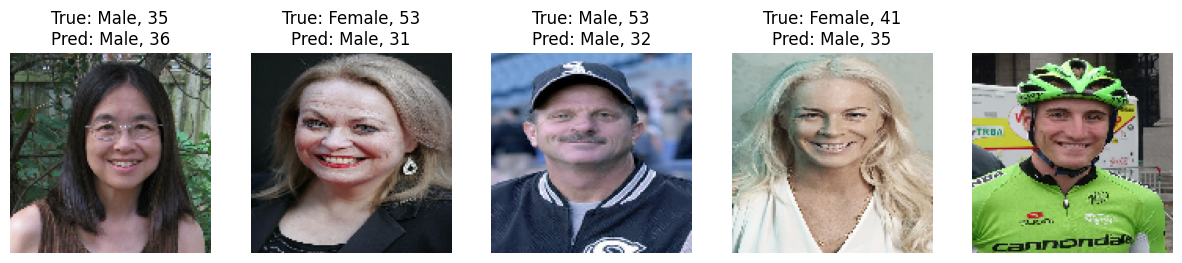

In [ ]:
# **Step 8: Visualize Predictions**
def visualize_predictions(image_paths, true_genders, pred_genders, true_ages, pred_ages, n=5):
    """Display random predictions with true labels."""
    n = min(n, len(image_paths), len(true_genders), len(pred_genders), len(true_ages), len(pred_ages))  # Ensure valid range
    plt.figure(figsize=(15, 5))
    for i in range(n):
        idx = np.random.randint(len(image_paths))
        img = tf.keras.preprocessing.image.load_img(image_paths[idx], target_size=(128, 128))
        img = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        true_gender = "Male" if true_genders[idx] == 1 else "Female"
        pred_gender = "Male" if pred_genders[idx] == 1 else "Female"
        plt.title(f"True: {true_gender}, {int(true_ages[idx])}\nPred: {pred_gender}, {int(pred_ages[idx])}")
    plt.show()

visualize_predictions(test_image_paths, true_genders, predicted_genders, true_ages, predicted_ages)